# Academia

### Diagrama

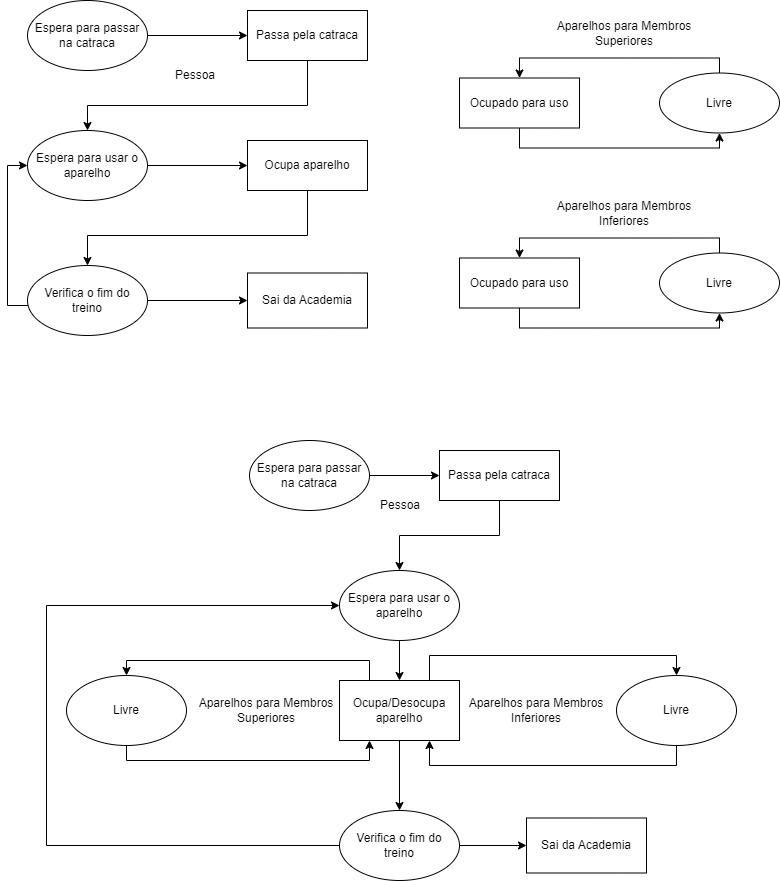

## Código

### Import Libs

In [291]:
import random
import simpy
import statistics
import seaborn as sns
import pandas as pd
import time

from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [292]:
treinos = {0: 'costa', 1: 'bicep', 2: 'peito', 3: 'tricep', 4: 'abdomen', 5: 'perna'}
aparelhos = {}

In [293]:
class Pessoa():
    
    def __init__(self, tempo_treino=0) -> None:
        self.treino = []
        self.tempo_treino = tempo_treino
        
        self.tipos_aparelhos = {0: 'costa', 1: 'bicep', 2: 'peito', 3: 'tricep', 4: 'abdomen', 5: 'perna'}

    def montar_treino(self, quantidade_exercicios):
        for _ in range(quantidade_exercicios):
            self.treino.append(random.choice(list(self.tipos_aparelhos.keys())))
            
    def fazer_exercicio(self):
        treino = self.treino.pop(0)
        return (treino, self.tipos_aparelhos.get(treino))
    
    def get_treino(self):
        return self.treino

class Aparelho():
    
    def __init__(self, tipo_aparelho: list, qtd_aparelho, env) -> None:
        self.tipo_aparelho = tipo_aparelho
        self.qtd = qtd_aparelho

        self.tempo_fila = []
        self.tempo_ocupado = []
        self.ocioso = []
        self.utilizacao = 0
        self.ocupado = False
        
        self.resource = simpy.Resource(env, capacity=qtd_aparelho)
        self.tipos_aparelhos = {0: 'costa', 1: 'bicep', 2: 'peito', 3: 'tricep', 4: 'abdomen', 5: 'perna'}
    
    def get_tipo(self):
        return [self.tipos_aparelhos.get(x) for x in self.tipo_aparelho]
    
    def get_tempo(self):
        return self.tempo_ocupado
    
    def set_tempo(self, tempo):
        return self.tempo_ocupado.append(tempo)
    
    def get_tempo_fila(self):
        return self.tempo_fila
    
    def set_tempo_fila(self, tempo):
        return self.tempo_fila.append(tempo)

    def add_util(self):
        self.utilizacao += 1
        return self.utilizacao
    
    def get_util(self):
        return self.utilizacao
    
    def get_ocup(self):
        return self.ocupado
    
    def set_ocup(self):
        self.ocupado = not self.ocupado
        return self.ocupado
    
    def set_ocioso(self, tempo):
        return self.ocioso.append(tempo)
    
    def get_ocioso(self):
        return self.ocioso
        
    def get_resource(self):
        return self.resource

In [294]:
test = Pessoa()
test.montar_treino(quantidade_exercicios=5)
print(test.treino)

[0, 3, 1, 4, 4]


In [295]:
def create_machines(qtd=2):
    for key,value in treinos.items():
        for _ in range(qtd):
            if key not in aparelhos.keys():
                aparelhos[key] = []
            aparelhos[key].append(Aparelho(value))

In [296]:
def print_machines(aparelhos_lst):
    for key, lst_value in aparelhos_lst.items():
        for value in lst_value:
            print(value.get_tipo())
            print(value.get_tempo())

## Prep Time

In [297]:
df_times = pd.read_excel('intervalos_chegada_academia.xlsx')
df_times['Intervalo']

0       33
1      292
2       85
3     1250
4       44
      ... 
94     258
95      69
96     478
97     744
98    2171
Name: Intervalo, Length: 99, dtype: int64

In [298]:
df_times['Intervalo'].max()

np.int64(2171)

In [299]:
df_times['Intervalo'].mean()

np.float64(168.3838383838384)

In [300]:
df_times['Intervalo'].std()

np.float64(300.56483245989887)

In [301]:
pd.melt(df_times, value_vars=['Intervalo'])

,variable,value
0,Intervalo,33
1,Intervalo,292
2,Intervalo,85
3,Intervalo,1250
4,Intervalo,44
...,...,...
94,Intervalo,258
95,Intervalo,69
96,Intervalo,478
97,Intervalo,744


### Dados Reais

<Axes: xlabel='Intervalo', ylabel='Count'>

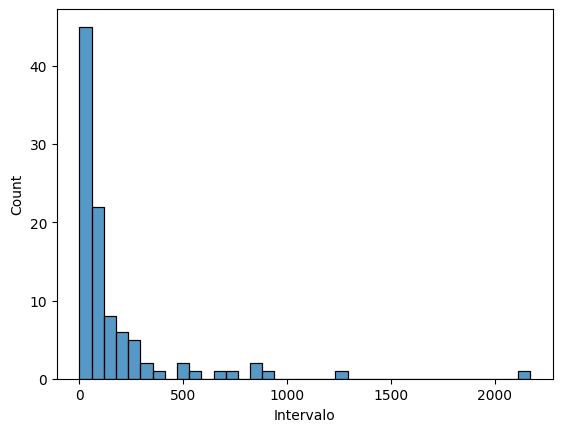

In [302]:
sns.histplot(data=df_times, x = 'Intervalo')

In [303]:
1/(df_times['Intervalo'].mean()) * 60

np.float64(0.3563287342531493)

### Dados Criados pela distribuição

<Axes: ylabel='Count'>

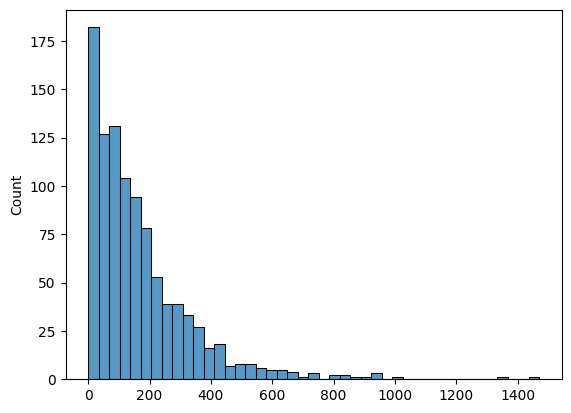

In [304]:
random.seed(10)
sns.histplot([random.expovariate(1.0/df_times['Intervalo'].mean()) for x in range(1000)])

### Execucao

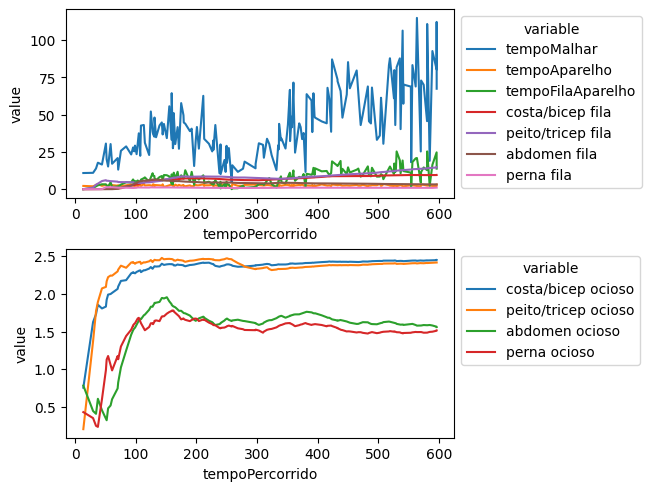

In [305]:
contaClientes = 0             # conta clientes que chegaram no sistema

tempoPercorrido = []
tempoMalhar = [] #done
tempoFilaCatraca = [] #done
tempoAparelho = [] #done
#tempoOcioso = [] #done
tempoFilaAparelho = [] #done


time_dict = {
    'tempoPercorrido': tempoPercorrido,
    'tempoMalhar': tempoMalhar,
    #'tempoFilaCatraca': tempoFilaCatraca,
    'tempoAparelho': tempoAparelho,
    #'tempoOcioso': tempoOcioso,
    'tempoFilaAparelho': tempoFilaAparelho
}

ocioso_dict = {
    'tempoPercorrido': tempoPercorrido,
}

def distributions(tipo):
    # função que armazena as distribuições utilizadas no modelo
    return {
        'chegadas': random.expovariate(1/df_times['Intervalo'].mean() * 60),
        'catraca': 3/60,
        'tempo_exercicio': random.uniform(1, 4),
        'qtd_exercicio': random.uniform(3,6)
    }.get(tipo, 0.0)

def chegadaClientes(env, catraca, aparelhos):
    # função que gera a chegada de clientes
    global contaClientes
    while True:
        yield env.timeout(distributions('chegadas'))
        contaClientes += 1
        cliente = Pessoa()
        cliente.montar_treino(quantidade_exercicios=int(distributions('qtd_exercicio')))
        #print(f"Cliente {contaClientes} chega em: {env.now}")
        
        # chamada do processo de catraca
        inicio_fila_catraca = env.now

    
        # ocupa catraca
        req_catraca = catraca.request()
        yield req_catraca
        termino_fila_catraca = inicio_fila_catraca
        #print(f'Catraca inicia, Cliente {contaClientes} as: {env.now}')
        inicio_fila_catraca = env.now
        yield env.timeout(distributions('catraca'))
        
        
        #libera catraca
        yield catraca.release(req_catraca)
        #print(f'Catraca liberada, Cliente {contaClientes} as: {env.now}')
        
        env.process(malhar(env, aparelhos, contaClientes, cliente))
        
        
def malhar(env, aparelhos, contaClientes, cliente):
    inicio_malhar = env.now
    tempo_aparelho_aux = []
    fila_aparelho_aux = []
    #print(f'Cliente: {contaClientes} inicia rotina de treino as {env.now}')
    while cliente.get_treino():
        inicio_fila_aparelho = env.now
        id_exercicio, exercicio = cliente.fazer_exercicio()
        aparelho_obj = aparelhos.get(id_exercicio)
        aparelho = aparelho_obj.get_resource()
        req_aparelho = aparelho.request()
        yield req_aparelho
        termino_fila_aparelho = env.now - inicio_fila_aparelho 
        inicio_aparelho = env.now
        aparelho_obj.set_ocup()
        aparelhos_ociosos = get_aparelho_ocioso(env, aparelhos)
        #print(aparelhos_ociosos)
        #print(f'Cliente: {contaClientes} inicia treino na maquina de {exercicio} as {env.now}')
        yield env.timeout(distributions('tempo_exercicio'))
        yield aparelho.release(req_aparelho)
        get_aparelho_ocioso_tempo(env, aparelhos_ociosos, aparelhos) 
        aparelho_obj.set_ocup()
        #print(f'Cliente: {contaClientes} termina treino na maquina de {exercicio} as {env.now}')
        termino_aparelho = env.now - inicio_aparelho 
        fila_aparelho_aux.append(termino_fila_aparelho)
        tempo_aparelho_aux.append(termino_aparelho)
        aparelho_obj.add_util()
        aparelho_obj.set_tempo(termino_aparelho)
        aparelho_obj.set_tempo_fila(termino_fila_aparelho)
        #print('Fila', get_fila_aparelhos(aparelhos))
    
    #mean_ocioso_aparelho = get_ociosity_mean(get_tempo_ocioso_aparelhos(aparelhos))
    mean_termino_aparelho = statistics.mean(tempo_aparelho_aux)
    termino_malhar = env.now - inicio_malhar
    mean_fila_aparelho = statistics.mean(fila_aparelho_aux)
    # print(f'Cliente {contaClientes} fez seu treino completo em {termino_malhar}')
    # print('Util', get_util_aparelhos(aparelhos))
    # print('Tempo', get_tempo_aparelhos(aparelhos))
    # print('Ociosidade', get_tempo_ocioso_aparelhos(aparelhos))
    # print('Ociosidade', get_tempo_ocioso_aparelhos_len(aparelhos))
    get_tempo_ocioso_aparelhos(aparelhos)
    get_ociosity_mean(get_tempo_ocioso_aparelhos(aparelhos), ocioso_dict)
    get_fila_mean(get_tempo_fila_aparelhos(aparelhos), time_dict)
    
    tempoPercorrido.append(env.now)
    tempoMalhar.append(termino_malhar)
    tempoAparelho.append(mean_termino_aparelho)
    tempoFilaAparelho.append(mean_fila_aparelho)
    #tempoOcioso.append(mean_ocioso_aparelho)
    #print(time_dict)




def get_fila_aparelhos(aparelhos):
    return [(aparelhos.get(x).get_tipo(), len(aparelhos.get(x).get_resource().queue)) for x in aparelhos.keys()]

def get_util_aparelhos(aparelhos):
    return [(aparelhos.get(x).get_tipo(), aparelhos.get(x).get_util()) for x in aparelhos.keys()]

def get_tempo_aparelhos(aparelhos):
    return [(aparelhos.get(x).get_tipo(), aparelhos.get(x).get_tempo()) for x in aparelhos.keys()]

def get_tempo_ocioso_aparelhos_len(aparelhos):
    return [(aparelhos.get(x).get_tipo(), len(aparelhos.get(x).get_ocioso())) for x in aparelhos.keys()]

def get_tempo_ocioso_aparelhos(aparelhos):
    return [(aparelhos.get(x).get_tipo(), aparelhos.get(x).get_ocioso()) for x in aparelhos.keys()]

def get_tempo_fila_aparelhos(aparelhos):
    return [(aparelhos.get(x).get_tipo(), aparelhos.get(x).get_tempo_fila()) for x in aparelhos.keys()]

def get_aparelho_ocioso(env, aparelhos):
    ociosidade_dict = {}
    for k,v in aparelhos.items():
        if v.get_ocup():
            ociosidade_dict[k] = env.now
        else:
            ociosidade_dict[k] = 0
    return ociosidade_dict

def get_aparelho_ocioso_tempo(env, aparelhos_ociosos, aparelhos):
    dup_obj = []
    for k, tempo_inicio in aparelhos_ociosos.items():
        if aparelhos_ociosos[k] and aparelhos[k] not in dup_obj:
            aparelhos[k].set_ocioso(env.now - tempo_inicio)
        elif aparelhos_ociosos[k] == 0 and aparelhos[k] not in dup_obj:
            aparelhos[k].set_ocioso(0)

        dup_obj.append(aparelhos[k])
        
def get_ociosity_mean(tempos_ociosos, dicts):
    #dict_ocioso = {}
    dup_list = []
    for tempos in tempos_ociosos:
        if tempos not in dup_list:
            if '/'.join(tempos[0]) + ' ocioso' not in dicts:
                dicts['/'.join(tempos[0]) + ' ocioso'] = [statistics.mean(tempos[1])]
            else:
                dicts['/'.join(tempos[0]) + ' ocioso'].append(statistics.mean(tempos[1]))
        dup_list.append(tempos)
    #return dict_ocioso

def get_fila_mean(tempos_fila, dicts):
    #dict_ocioso = {}
    dup_list = []
    for tempos in tempos_fila:
        if tempos not in dup_list:
            if '/'.join(tempos[0]) + ' fila' not in dicts:
                dicts['/'.join(tempos[0]) + ' fila'] = [statistics.mean(tempos[1])]
            else:
                dicts['/'.join(tempos[0]) + ' fila'].append(statistics.mean(tempos[1]))
        dup_list.append(tempos)
    #return dict_ocioso
    

def get_aparelho_ocioso_tempo(env, aparelhos_ociosos, aparelhos):
    dup_obj = []
    for k, tempo_inicio in aparelhos_ociosos.items():
        if aparelhos_ociosos[k]:
            aparelhos[k].set_ocioso(env.now - tempo_inicio)
        elif aparelhos_ociosos[k] == 0:
            aparelhos[k].set_ocioso(0)

        dup_obj.append(aparelhos_ociosos[k])
        
            

random.seed(10)
env = simpy.Environment()
catraca = simpy.Resource(env, capacity=1)
# Init machines 
#{0: 'costa', 1: 'bicep', 2: 'peito', 3: 'tricep', 4: 'abdomen', 5: 'perna'}

aparelho_biceps = Aparelho(tipo_aparelho=[0,1], qtd_aparelho=1, env=env)
aparelho_triceps = Aparelho(tipo_aparelho=[2,3], qtd_aparelho=1, env=env)
aparelho_abdomen = Aparelho(tipo_aparelho=[4], qtd_aparelho=1, env=env)
aparelho_perna = Aparelho(tipo_aparelho=[5], qtd_aparelho=1, env=env)

aparelhos = {0:aparelho_biceps, 1:aparelho_biceps, 2:aparelho_triceps, 3:aparelho_triceps,4:aparelho_abdomen, 5:aparelho_perna}
env.process(chegadaClientes(env, catraca, aparelhos))

env.run(until=600)
#print(time_dict)

# df_time = pd.DataFrame(data=time_dict)
# df_ocioso = df = pd.DataFrame(data=ocioso_dict)

#fig, ax = plt.subplots()


# def animate(i):
#     ax.clear()
#     x_labels = df['tempoPercorrido'][:i+1]
#     ax.set_xlim([1, 600])
#     ax.set_xlabel('Time', fontsize=14)
#     ax.set_ylabel('value', fontsize=14)
#     sns.lineplot(x=x_labels, y=df_time['tempoMalhar'][:i+1], ax=ax, label='tempoMalhar')
#     sns.lineplot(x=x_labels, y=df_time['tempoAparelho'][:i+1], ax=ax, label='tempoAparelho')
#     sns.lineplot(x=x_labels, y=df_time['tempoFilaAparelho'][:i+1], ax=ax, label='tempoFilaAparelho')
#     sns.lineplot(x=x_labels, y=df_time['costa/bicep fila'][:i+1], ax=ax, label='costa/bicep fila')
#     sns.lineplot(x=x_labels, y=df_time['peito/tricep fila'][:i+1], ax=ax, label='peito/tricep fila')
#     sns.lineplot(x=x_labels, y=df_time['abdomen fila'][:i+1], ax=ax, label='abdomen fila')
#     sns.lineplot(x=x_labels, y=df_time['perna fila'][:i+1], ax=ax, label='perna fila')
    
# #plt.show()
# plt.close()

# anim = animation.FuncAnimation(fig, animate, frames=int(len(df_time)*1.1))
# anim.save('test.gif')
# Image("test.gif")


fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=True)

df = pd.DataFrame(data=time_dict)
plot1 = sns.lineplot(data=pd.melt(df, ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable', ax=axs[0])
sns.move_legend(plot1, "upper left", bbox_to_anchor=(1, 1))

df = pd.DataFrame(data=ocioso_dict)
#print(ocioso_dict)
plot2 = sns.lineplot(pd.melt(df, ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable', ax=axs[1])
sns.move_legend(plot2, "upper left", bbox_to_anchor=(1, 1))

{'tempoPercorrido': [np.float64(13.262260094572092), np.float64(29.360298648702678), np.float64(34.217025557466705), np.float64(37.3017744491466), np.float64(44.019215289805985), np.float64(50.54328593695058), np.float64(51.79448158134315), np.float64(54.169666893411005), np.float64(58.292225818493435), np.float64(60.75356585305354), np.float64(69.89256495908532), np.float64(70.83961325372113), np.float64(75.33366000024691), np.float64(83.95199962191539), np.float64(92.29790036493989), np.float64(95.40852543514761), np.float64(95.45208489989238), np.float64(97.45361871627794), np.float64(98.57797416638496), np.float64(101.22466514733212), np.float64(103.02311493445255), np.float64(104.8447733469448), np.float64(107.24177906729682), np.float64(108.40649364795387), np.float64(113.14808331962897), np.float64(114.88017277376366), np.float64(121.96832820430907), np.float64(124.70771077303036), np.float64(127.65422767844403), np.float64(128.41534953755837), np.float64(130.49557183278935), np

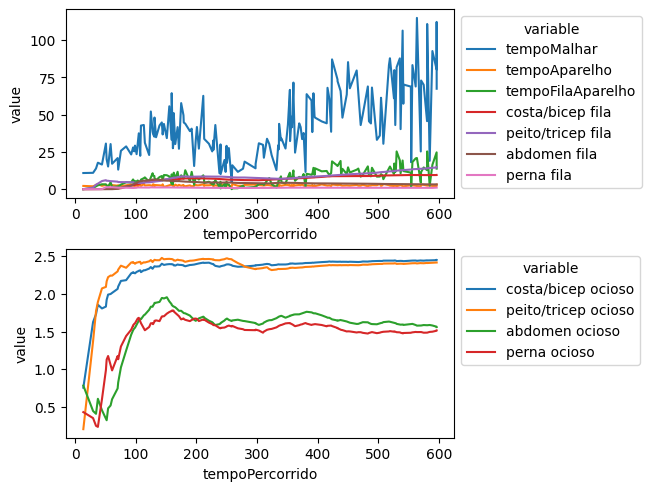

In [306]:
fig, axs = plt.subplots(ncols=1, nrows=2, constrained_layout=True)

df = pd.DataFrame(data=time_dict)
plot1 = sns.lineplot(data=pd.melt(df, ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable', ax=axs[0])
sns.move_legend(plot1, "upper left", bbox_to_anchor=(1, 1))

df = pd.DataFrame(data=ocioso_dict)
print(ocioso_dict)
plot2 = sns.lineplot(pd.melt(df, ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable', ax=axs[1])
sns.move_legend(plot2, "upper left", bbox_to_anchor=(1, 1))

# Lavanderia

### Diagrama

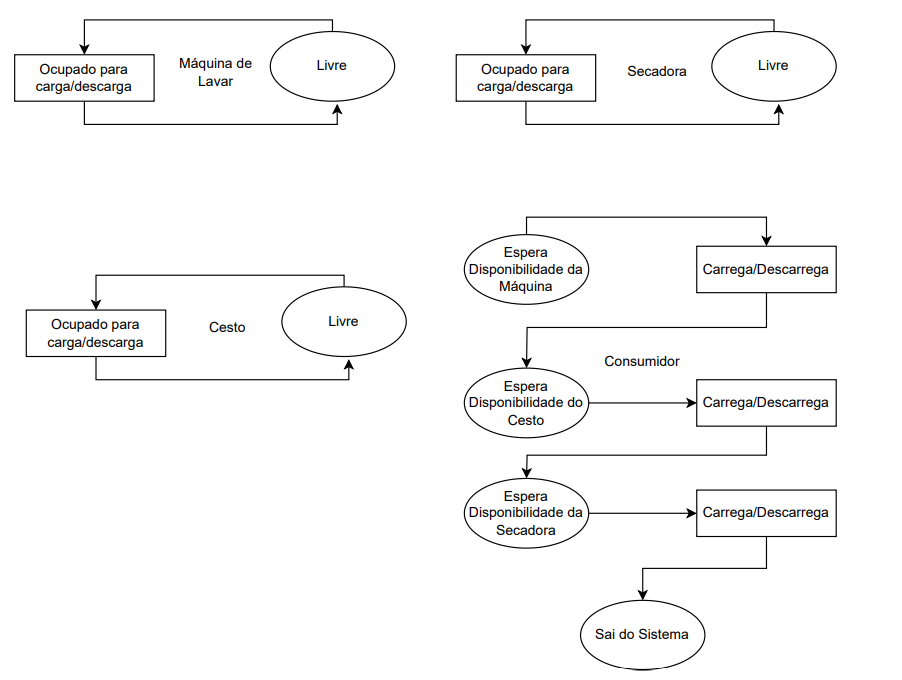

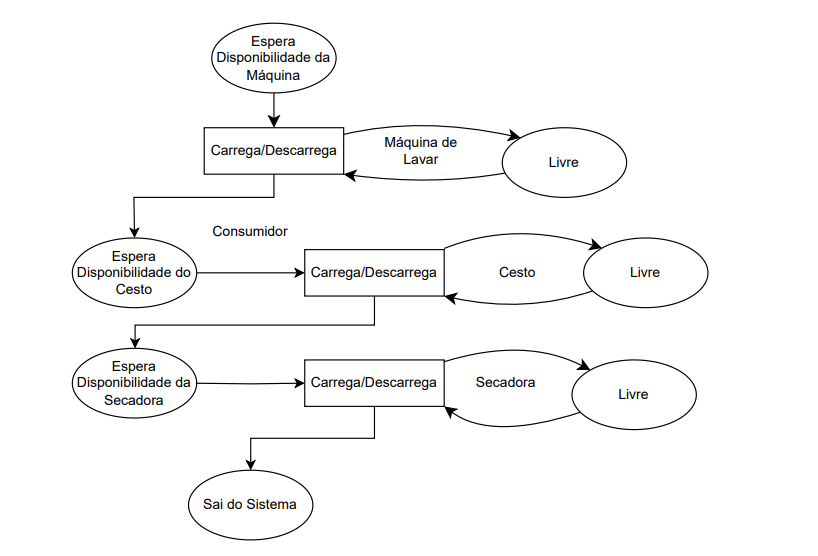

### Código

In [307]:
import random
import simpy
import statistics
import seaborn as sns
import pandas as pd
import numpy as np
import time

from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Prep time

In [308]:
df_times = pd.read_excel('intervalos_chegada_lavanderia.xlsx')
df_times['Intervalo']

0     128
1      52
2      60
3       0
4      60
     ... 
94     66
95     15
96     98
97     34
98     23
Name: Intervalo, Length: 99, dtype: int64

In [309]:
df_times['Intervalo'].max()

np.int64(500)

In [310]:
df_times['Intervalo'].mean()

np.float64(63.464646464646464)

In [311]:
df_times['Intervalo'].std()

np.float64(77.20160635043821)

In [312]:
pd.melt(df_times, value_vars=['Intervalo'])

,variable,value
0,Intervalo,128
1,Intervalo,52
2,Intervalo,60
3,Intervalo,0
4,Intervalo,60
...,...,...
94,Intervalo,66
95,Intervalo,15
96,Intervalo,98
97,Intervalo,34


### Dados Reais

<Axes: xlabel='Intervalo', ylabel='Count'>

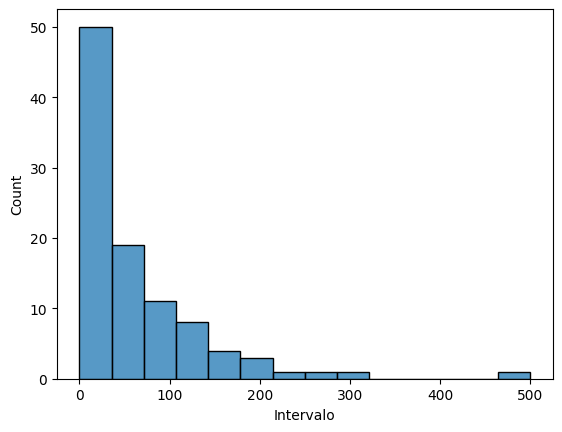

In [313]:
sns.histplot(data=df_times, x = 'Intervalo')

In [314]:
1/df_times['Intervalo'].mean()

np.float64(0.01575680407448671)

### Dados Criados pela distribuição

<Axes: ylabel='Count'>

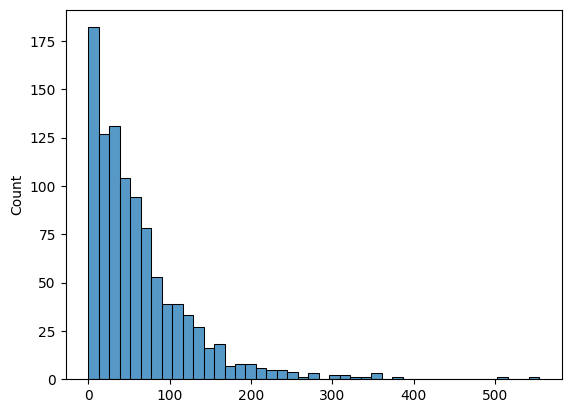

In [386]:
random.seed(10)
sns.histplot([random.expovariate(1.0/df_times['Intervalo'].mean()) for x in range(1000)])

In [401]:
contaClientes = 0             # conta clientes que chegaram no sistema

#CUSTO ENERGIA E AGUA
CUSTO_AGUA_LITRO = 0.00294 #https://arbel.belem.pa.gov.br/wp-content/uploads/2022/05/APRESENTA%C3%87%C3%83O-ARBEL.pdf
CUSTO_ENERGIA_KWH = 0.93845 #https://pa.equatorialenergia.com.br/informacoes-gerais/valor-de-tarifas-e-servicos/#demais-classes

#ESTUDO ESTABELECIMENTO, TEMPOS DE LAVAGEM E SECAGEM:
#https://www.omolavanderia.com.br/quem-somos
TEMPO_LAVAGEM = 30
TEMPO_SECAGEM = 45
RECEITA_CICLO = 18.5

#CONSUMO LAVADORA DANVIC MODELO MXR55PNATS
#http://www.danvic.com/wp-content/uploads/2014/09/MXR_OPL_SpecSht_R_PT.pdf

LAVADORA_CONSUMO_AGUA_LAVAGEM_LITRO = 50
LAVADORA_CONSUMO_ENERGIA_KWH = 2

#CONSUMO SECADORA MODELO UNIMAC UT120
#https://unimac.com/br/product/secadoras/secadoras-industriais/120lb-capacidade/
SECADORA_CONSUMO_ENERGIA_KWH = 2


tempoPercorrido = [] #done
tempoTotalCliente = [] #done
tempoFilaLavadoras = [] #done
tempoFilaSecadoras = [] 
tempoFilaCestos = []
tempoLavadoras = [] #done
tempoCestos = [] #done
tempoSecadoras = [] #done
consumoEnergiaLavadora=[]
consumoEnergiaSecadora=[]
consumoAguaLavadora=[]
custoEnergiaLavadora=[]
custoEnergiaSecadora=[]
custoAguaLavadora=[]
custoTotal=[]
receitaGerada=[]

time_dict = {
    'tempoPercorrido': tempoPercorrido,
    'tempoTotalCliente': tempoTotalCliente,
    'tempoFilaSecadoras': tempoFilaSecadoras,
    'tempoFilaCestos': tempoFilaCestos,
    'tempoFilaLavadoras': tempoFilaLavadoras,
    # 'tempoLavadoras': tempoLavadoras,
    # 'tempoCestos': tempoCestos,
    # 'tempoSecadoras': tempoSecadoras,
}

consumo_dict = {
    'tempoPercorrido': tempoPercorrido,
    'consumoEnergiaLavadora': consumoEnergiaLavadora,
    'consumoEnergiaSecadora': consumoEnergiaSecadora,
    'consumoAguaLavadora': consumoAguaLavadora,
}

custo_dict = {
    'tempoPercorrido': tempoPercorrido,
    'custoEnergiaLavadora': custoEnergiaLavadora,
    'custoEnergiaSecadora': custoEnergiaSecadora,
    'custoAguaLavadora': custoAguaLavadora,
}

capital_dict= {
    'tempoPercorrido': tempoPercorrido,
    "receitaGerada": receitaGerada,
    "custoTotal":custoTotal
}



def distributions(tipo):
    # função que armazena as distribuições utilizadas no modelo
    return {
        'chegadas': random.expovariate(1.0/df_times['Intervalo'].mean()),
        #'chegadas': random.expovariate(1.0/3.0),
        'lavar': TEMPO_LAVAGEM,
        'descarregar': random.uniform(1, 4),
        'carregar': 2,
        'transportar': random.uniform(3,5),
        'secar': TEMPO_SECAGEM,
    }.get(tipo, 0.0)

def chegadaClientes(env, lavadoras, cestos, secadoras):
    # função que gera a chegada de clientes
    global contaClientes
    while True:
        yield env.timeout(distributions('chegadas'))
        contaClientes += 1
        #print(f"Cliente {contaClientes} chega em: {env.now}")
        

    # chamada do processo de lavagem e secagem
        env.process(lavaSeca(env, contaClientes, lavadoras, cestos, secadoras))

def lavaSeca(env, cliente, lavadoras, cestos, secadoras):
    # função que processa a operação de cada cliente dentro da lavanderia
    inicio_geral = env.now

    inicio_fila = env.now

    
    # ocupa a lavadora
    req_lavadora = lavadoras.request()
    yield req_lavadora
    inicio_lavar = env.now
    #print(f'Lavadora inicia a lavagem do Cliente {cliente} as: {env.now}')
    
    termino_fila = env.now - inicio_fila
    
    
    yield env.timeout(distributions('lavar'))
    termino_lavar = env.now - inicio_lavar
    
    
    # antes de retirar da lavadora, pega um cesto
    inicio_fila_cesto = env.now
    req_cesto = cestos.request()
    yield req_cesto
    
    termino_fila_cesto = env.now - inicio_fila_cesto
    inicio_cesto = env.now
    #print(f'Cliente {cliente} ocupa o cesto as: {env.now}')
    #print(f'Cliente {cliente} inicia o descarregamento da maquina as: {env.now}')
    yield env.timeout(distributions('descarregar'))
    
    
    # libera a lavadora, mas não o cesto
    yield lavadoras.release(req_lavadora)
    #print(f'Cliente {cliente} desocupa a lavadora as: {env.now}')
    
    # cliente trasporta o cesto ate a maquina de secar
    #print(f'Cliente inicia o transporte das roupas para a máquina de secar as: {env.now}')
    yield env.timeout(distributions('transportar'))
    #print(f'Cliente terminar o transporte das roupas para a máquina de secar as: {env.now}')
    
    # ocupa a secadora antes de liberar o cesto
    inicio_fila_secadora = env.now
    req_secadora = secadoras.request()
    yield req_secadora
    inicio_secadoras = env.now
    termino_fila_secadora = env.now - inicio_fila_secadora
    #print(f'Cliente {cliente} ocupa a secadora as: {env.now}')
    yield env.timeout(distributions('carregar'))
    
    # libera o cesto mas não a secadora
    yield cestos.release(req_cesto)
    termino_cesto = env.now - inicio_cesto
    
    #print(f'Cliente {cliente} desocupa o cesto as: {env.now}')
    yield env.timeout(distributions('secar'))
    
    # pode liberar a secadora
    #print(f'Cliente {cliente} iniciar o descarregamento da secadora as: {env.now}')
    yield env.timeout(distributions('descarregar'))	
    
    yield secadoras.release(req_secadora)
    termino_secadoras = env.now - inicio_secadoras
    
    
    termino_geral = env.now - inicio_geral
    
    #print(f'Cliente {cliente} desocupa o secadora as: {env.now}')
    
    tempoSecadoras.append(termino_secadoras)
    tempoTotalCliente.append(termino_geral)
    tempoCestos.append(termino_cesto)
    tempoLavadoras.append(termino_lavar)
    tempoFilaLavadoras.append(termino_fila)
    tempoFilaCestos.append(termino_fila_cesto)
    tempoFilaSecadoras.append(termino_fila_secadora)
    tempoPercorrido.append((env.now/10080) + 1)
    
    #CALCULO CONSUMO
    ENERGIA_LAVADORA = sum(tempoLavadoras) * (LAVADORA_CONSUMO_ENERGIA_KWH / 60)
    ENERGIA_SECADORA = sum(tempoSecadoras) * (SECADORA_CONSUMO_ENERGIA_KWH / 60)
    AGUA_LAVADORA = len(tempoLavadoras) * LAVADORA_CONSUMO_AGUA_LAVAGEM_LITRO
    
    CUSTO_ENERGIA_LAVADORA=ENERGIA_LAVADORA * CUSTO_ENERGIA_KWH
    CUSTO_ENERGIA_SECADORA=ENERGIA_SECADORA * CUSTO_ENERGIA_KWH
    CUSTO_AGUA_LAVADORA=AGUA_LAVADORA * CUSTO_AGUA_LITRO
    
    RECEITA_GERADA = len(tempoLavadoras) * RECEITA_CICLO
    CUSTO_TOTAL = CUSTO_ENERGIA_LAVADORA + CUSTO_ENERGIA_SECADORA + CUSTO_AGUA_LAVADORA
    
    consumoEnergiaLavadora.append(ENERGIA_LAVADORA)
    consumoEnergiaSecadora.append(ENERGIA_SECADORA)
    consumoAguaLavadora.append(AGUA_LAVADORA)
    
    custoEnergiaLavadora.append(CUSTO_ENERGIA_LAVADORA)
    custoEnergiaSecadora.append(CUSTO_ENERGIA_SECADORA)
    custoAguaLavadora.append(CUSTO_AGUA_LAVADORA)
    
    receitaGerada.append(RECEITA_GERADA)
    custoTotal.append(CUSTO_TOTAL)
    #print('custo total', CUSTO_ENERGIA_LAVADORA+CUSTO_ENERGIA_SECADORA+CUSTO_AGUA_LAVADORA)
    

#random.seed(10)
env = simpy.Environment()
lavadoras = simpy.Resource(env, capacity=10)
cestos = simpy.Resource(env, capacity=10)
secadoras = simpy.Resource(env, capacity=10)
env.process(chegadaClientes(env, lavadoras, cestos, secadoras))

env.run(until=43200)

fig, ax = plt.subplots()

time_df = pd.DataFrame(data=time_dict)
sns.lineplot(pd.melt(time_df, ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable')

consumo_df = pd.DataFrame(data=consumo_dict)
sns.lineplot(pd.melt(time_df, ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable')

custo_df = pd.DataFrame(data=custo_dict)
custo_total = pd.melt(custo_df, ['tempoPercorrido'])
capital_df = pd.DataFrame(data=capital_dict)

def animate(i):
    ax.clear()
    x_labels = df['tempoPercorrido'][:i+1]
    ax.set_xlim([1, 1200])
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('value', fontsize=14)
    sns.lineplot(x=x_labels, y=df['tempoTotalCliente'][:i+1], ax=ax, label='tempoTotalCliente')
    sns.lineplot(x=x_labels, y=df['tempoFilaLavadoras'][:i+1], ax=ax, label='tempoFilaLavadoras')
    sns.lineplot(x=x_labels, y=df['tempoFilaCestos'][:i+1], ax=ax, label='tempoFilaCestos')
    sns.lineplot(x=x_labels, y=df['tempoFilaSecadoras'][:i+1], ax=ax, label='tempoFilaSecadoras')
    sns.lineplot(x=x_labels, y=df['tempoLavadoras'][:i+1], ax=ax, label='tempoLavadoras')
    sns.lineplot(x=x_labels, y=df['tempoCestos'][:i+1], ax=ax, label='tempoCestos')
    sns.lineplot(x=x_labels, y=df['tempoSecadoras'][:i+1], ax=ax, label='tempoSecadoras')
    

#plt.show()
plt.close()

# anim = animation.FuncAnimation(fig, animate, frames=len(df)*2)
# anim.save('test.gif')
# Image("test.gif")



In [402]:
time_df['tempoTotalCliente'] = time_df['tempoTotalCliente'].rolling(window=10).mean()
time_df['tempoFilaSecadoras'] = time_df['tempoFilaSecadoras'].rolling(window=10).mean()
time_df['tempoFilaCestos'] = time_df['tempoFilaCestos'].rolling(window=10).mean()
time_df['tempoFilaLavadoras'] = time_df['tempoFilaLavadoras'].rolling(window=10).mean()

<Axes: xlabel='tempoPercorrido', ylabel='value'>

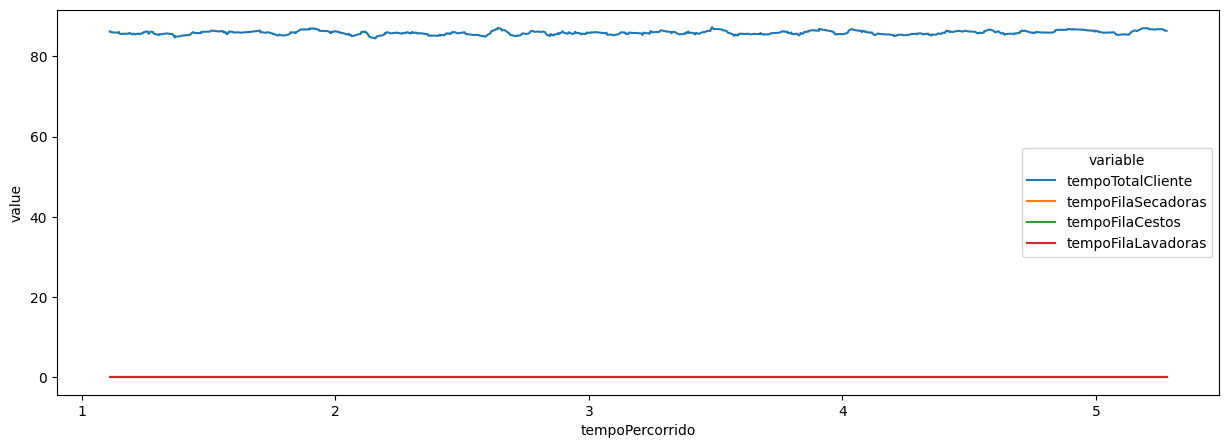

In [403]:
plt.figure(figsize=(15, 5))
sns.lineplot(pd.melt(time_df, ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable')

In [404]:
consumo_df

,tempoPercorrido,consumoEnergiaLavadora,consumoEnergiaSecadora,consumoAguaLavadora
0,1.017255,1.0,1.626611,50
1,1.019709,2.0,3.306262,100
2,1.027387,3.0,4.941263,150
3,1.042674,4.0,6.624167,200
4,1.051623,5.0,8.261118,250
...,...,...,...,...
639,5.260395,640.0,1055.487710,32000
640,5.262706,641.0,1057.154411,32050
641,5.265245,642.0,1058.841647,32100
642,5.274335,643.0,1060.444801,32150


<Axes: xlabel='tempoPercorrido', ylabel='value'>

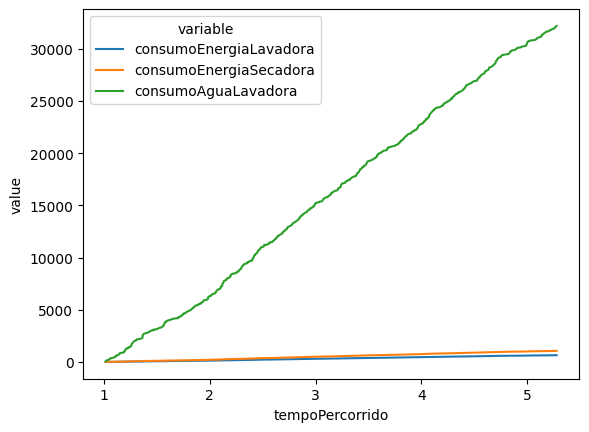

In [405]:
sns.lineplot(pd.melt(consumo_df, ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable')

<Axes: xlabel='tempoPercorrido', ylabel='value'>

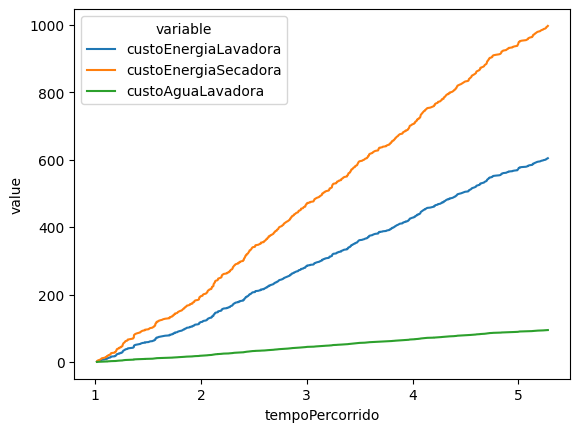

In [406]:
sns.lineplot(pd.melt(custo_df, ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable')

In [407]:
custo_df

,tempoPercorrido,custoEnergiaLavadora,custoEnergiaSecadora,custoAguaLavadora
0,1.017255,0.93845,1.526493,0.147
1,1.019709,1.87690,3.102761,0.294
2,1.027387,2.81535,4.637129,0.441
3,1.042674,3.75380,6.216449,0.588
4,1.051623,4.69225,7.752646,0.735
...,...,...,...,...
639,5.260395,600.60800,990.522441,94.080
640,5.262706,601.54645,992.086557,94.227
641,5.265245,602.48490,993.669944,94.374
642,5.274335,603.42335,995.174424,94.521


In [408]:
lucro_total = pd.melt(capital_df, ['tempoPercorrido']).groupby(['tempoPercorrido']).sum()


In [409]:
lucro_total

,variable,value
tempoPercorrido,,
1.017255,receitaGeradacustoTotal,21.111943
1.019709,receitaGeradacustoTotal,42.273661
1.027387,receitaGeradacustoTotal,63.393479
1.042674,receitaGeradacustoTotal,84.558249
1.051623,receitaGeradacustoTotal,105.679896
...,...,...
5.260395,receitaGeradacustoTotal,13525.210441
5.262706,receitaGeradacustoTotal,13546.360007
5.265245,receitaGeradacustoTotal,13567.528844


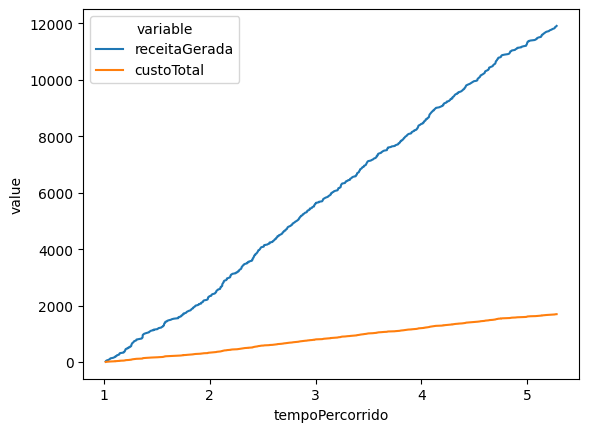

In [410]:
custo_total_plot = sns.lineplot(pd.melt(capital_df, ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable')

In [411]:
capital_df['lucro'] = capital_df['receitaGerada'] - capital_df['custoTotal']

In [412]:
capital_df = capital_df[['lucro', 'tempoPercorrido']]

In [413]:
capital_df

,lucro,tempoPercorrido
0,15.888057,1.017255
1,31.726339,1.019709
2,47.606521,1.027387
3,63.441751,1.042674
4,79.320104,1.051623
...,...,...
639,10154.789559,5.260395
640,10170.639993,5.262706
641,10186.471156,5.265245
642,10202.381226,5.274335


<Axes: xlabel='tempoPercorrido', ylabel='value'>

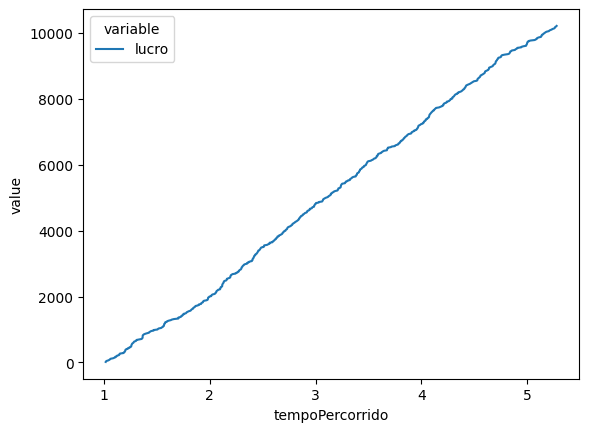

In [414]:
sns.lineplot(pd.melt(capital_df[['lucro', 'tempoPercorrido']], ['tempoPercorrido']),x='tempoPercorrido', y='value', hue='variable')